In [1]:
import sys
import numpy as np
import phate
import graphtools as gt
import numpy as np
import pygsp
from src.mds import embed_MDS
import scprep
from scipy.spatial.distance import jensenshannon
from src.embedding import EmbJSD, Embheatgeo, EmbHeatPHATE, EmbCTD, EmbGraphMMD, EmbMarheatgeo, CraneEmb, HeatGeo
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import umap
from dotenv import load_dotenv
import os
import seaborn as sns
from sklearn.manifold import TSNE

/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-26 13:44:21.174806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 13:44:23.135397: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-26 13:44:23.135514: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you

In [2]:
data_dir = os.environ.get("SHARE_DATA")
data_file = "eb_velocity_v5.npz"
data_dict = np.load(os.path.join(data_dir,data_file), allow_pickle=True) # 100 pca dimensions

In [3]:
for key in data_dict.keys():
    print(key)

pcs
phate
delta_embedding
color
ixs
sample_labels
pcs_delta


In [91]:
np.random.seed(50)
labels = data_dict["sample_labels"]
X = data_dict["pcs"]
rand_idx = np.random.choice(np.arange(X.shape[0]), size=3000, replace=False)
X_sub = X[rand_idx]

In [92]:
knn = 20
tau = 10
methods = {
    "UMAP": umap.UMAP(n_neighbors=knn),
    "t-SNE": TSNE(),
    "PHATE": phate.PHATE(knn=knn, verbose=False),
    "Heat-PHATE": EmbHeatPHATE(knn=knn, tau=tau, anisotropy=0, filter_method="mar"),
    "heatgeo": HeatGeo(knn=knn, tau=tau,filter_method="mar"),
    "heatgeo Harnack": HeatGeo(knn=knn, tau=tau, harnack=True, filter_method="mar"),
    "heatgeo Denoise": HeatGeo(knn=knn, tau=tau, denoising=True, n_ref=200, filter_method="mar"),
}

In [93]:
embedding = []
n = len(methods)
for name, emb_op in methods.items():
    print(name)
    emb = emb_op.fit_transform(X_sub)
    embedding.append(emb)

UMAP
t-SNE


/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PHATE
Heat-PHATE
heatgeo
heatgeo Harnack
heatgeo Denoise


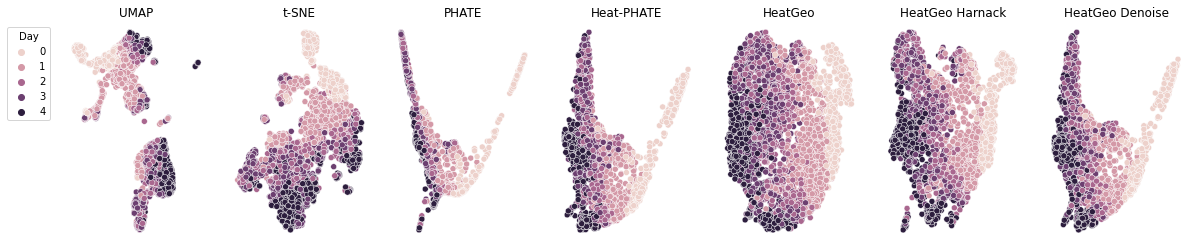

In [95]:
n = len(methods)
fig = plt.figure(figsize=(20, 4))
for i, (name,_) in enumerate(methods.items()):
    ax = fig.add_subplot(1, n, i+1)
    sns.scatterplot(x=embedding[i][:,0], y=embedding[i][:,1], hue=labels[rand_idx], ax=ax)
    ax.set_title(name)
    ax.axis("off")
    ax.legend(title="Day", bbox_to_anchor=(-0.1, 1.0))
    if i>0:
        ax.get_legend().remove()
fig.savefig("eb_all_emb.png", bbox_inches="tight")

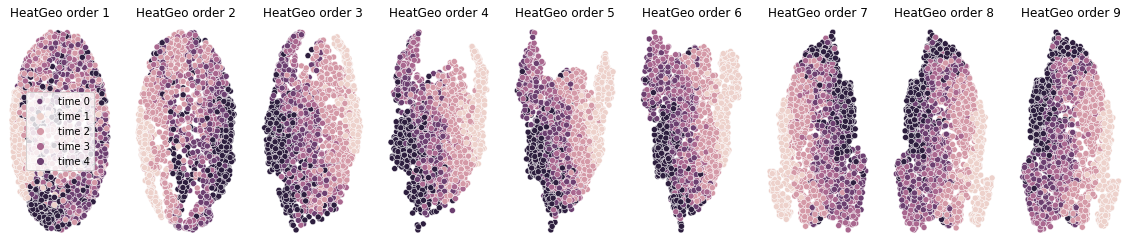

In [12]:
order_list = np.arange(1,10)
n = len(order_list)
fig = plt.figure(figsize=(20, 4))
for i, order in enumerate(order_list):
    emb_op = HeatGeo(knn=knn, tau=tau, order=order)
    emb = emb_op.fit_transform(X_sub)
    ax = fig.add_subplot(1, n, i+1)
    sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=labels[rand_idx], ax=ax)
    ax.set_title(f"heatgeo order {order}")
    ax.axis("off")
    ax.legend(["time 0", "time 1", "time 2", "time 3"], loc="upper left")
    if i>0:
        ax.get_legend().remove()
